In [5]:
import warnings
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
from matplotlib import cm
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
%matplotlib inline

import wget


**Загрузка изображения**

Загрузим любое изображение из интернета.

In [14]:
!wget https://i.pinimg.com/736x/a8/11/1a/a8111ab64125245b4b3e72f59d13d57c.jpg

--2022-12-07 20:54:26--  https://i.pinimg.com/736x/a8/11/1a/a8111ab64125245b4b3e72f59d13d57c.jpg
Resolving i.pinimg.com (i.pinimg.com)... 146.75.112.84
Connecting to i.pinimg.com (i.pinimg.com)|146.75.112.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49624 (48K) [image/jpeg]
Saving to: ‘a8111ab64125245b4b3e72f59d13d57c.jpg’

a8111ab64125245b4b3 100%[===================>]  48,46K  --.-KB/s    in 0,07s   

2022-12-07 20:54:27 (714 KB/s) - ‘a8111ab64125245b4b3e72f59d13d57c.jpg’ saved [49624/49624]



**Чтение изображения**

Image format: JPEG; shape: (736, 1095); color scheme: RGB


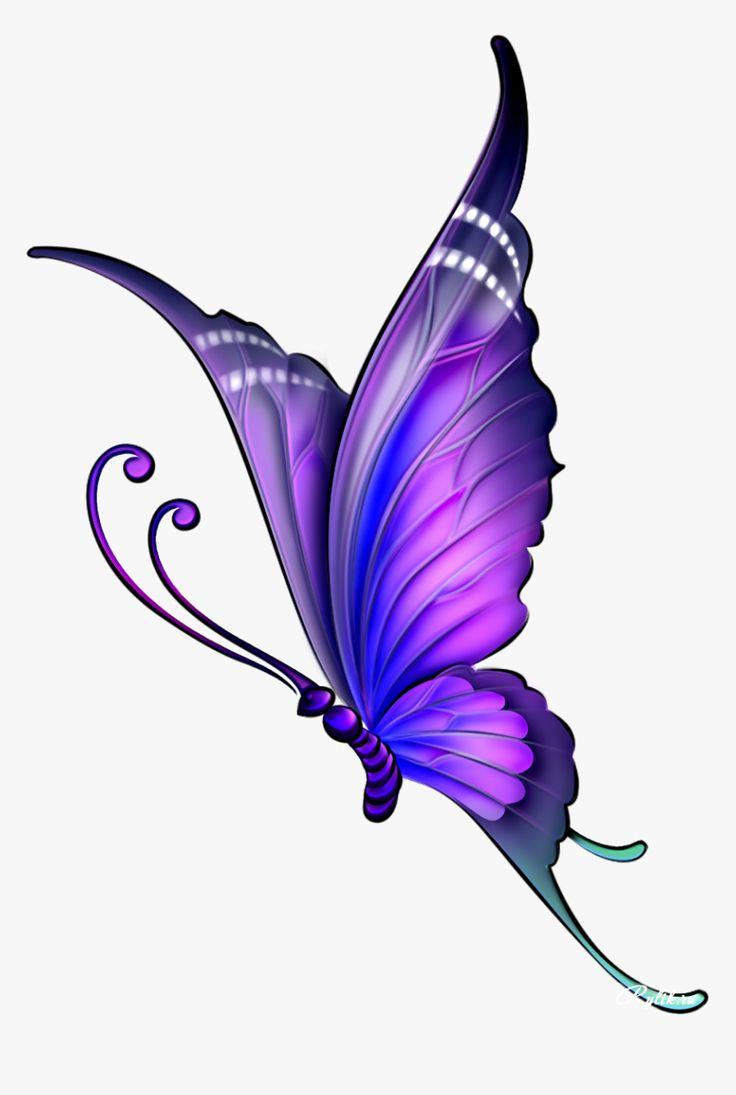

In [15]:
from PIL import Image

img = Image.open("a8111ab64125245b4b3e72f59d13d57c.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

**Матричное представление изображения**

Цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красный, зеленый, синий.

Image matrix shape: (1095, 736, 3)


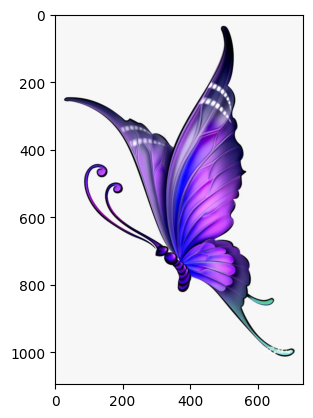

In [16]:
# получаем тензор
img_matrix = np.array(img)

# высота, ширина, число каналов (цветовых)
print(f"Image matrix shape: {img_matrix.shape}")

# нарисуем картинку с помощью matplotlib
plt.imshow(img_matrix)
plt.show()

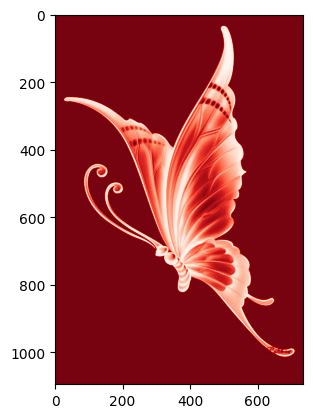

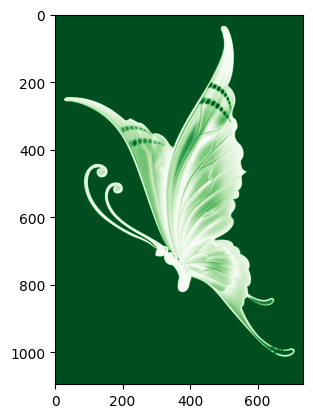

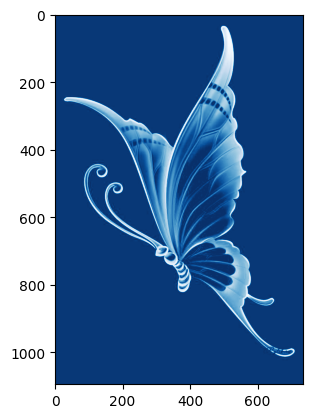

In [17]:
# 
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

**Операция свертки**

в Pytorch сверточный слой представлен в модуле `nn` функцией ``conv2d`` с параметрами:

- кол-во входных каналов `in_channels` RGB = 3
- кол-во выходных каналов `out_channels` кол-во фильтров/ сколько мы хотим получить признаков
- размер ядра `kernel_size` размер матрицы - можно взять и прямоугольник, но обычно верем квадрат нечетный, чтобы был центр - центральное значение
- шаг `stride` с которым мы проходим фильтром по изображению - напр шаг 1 пиксель или на 3 (в таком случае свертки не пересекаются, обычно нужно чтобы пересекалось) ! при увеличении шага выходное изображение уменьшится / можно задать шаг отдельно и по х и по у / по диагонали / можно создать кортеж / обычно применяют одинаковые шаги и по х и по у
- паддинг `padding` - мы вокруг изображения добавляем пиксели как рамочка вокруг например 1 или 2 пикселя - при применении свертки фильтр будет применяться и к самой картинке и на паддинг - таким образом мы не позволим изображению слишком быстро сжиматься искусственно увеличив изображение с помощью доп пикселей вокруг/ чем заполнять пиксели ? -> заполнить нулями или константами с учетом содержимого картинки в виде зеркального отображения элементов 
- режим паддинга `padding_mode` (`zeros, reflect` и др)
- `dilation` - раздутие: задаем расстояние между соседними пикселями фильтра - например в 1 пиксель - через один пиксель - игнорируя промежуточные пиксели (проскакивая их) - для изображений с высоким разрешением - где соседние пиксели не очень сильно отличаются 

**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свертка изображения.

https://github.com/vdumoulin/conv_arithmetic

**Шаг** - задает шаг в пикселях, на который свдигается фильтр. `int`, если по горизонтали и вертикали свдиг на одно и тоже число. Кортеж из двух чисел, если сдвиги разные.

**Свертка изображения**

Применим оператор Собеля для детектирования границ на изображении.

In [18]:
import torch
from torch.nn.functional import conv2d

In [19]:
# конвертируем изображение в нужный формат для pytorch

img_tensor = torch.tensor([img_matrix], dtype=torch.float)
img_tensor.size()   # число изображений, высота, ширина, число каналов 

torch.Size([1, 1095, 736, 3])

In [23]:
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.size()   # поменяли местами размерности, теперь: число изображений, число каналов, высота, ширина, так как у нас по формуле порядок для input(N, C, H, W)

torch.Size([1, 3, 1095, 736])

In [24]:
# зададим оператор Собеля для детектирования горизонтальных границ

sobel_hor = [[-1, -2, -1],
             [ 0,  0,  0],
             [ 1,  2,  1]]

# одна матрица на каждый канал картинки
kernel = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()   #число выходных каналов, число входных каналов, высота, ширина

torch.Size([1, 3, 3, 3])

In [25]:
# вернем картинку с подготовленным ядром свертки 
img_conv_hor = conv2d(img_tensor, kernel)
img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size()     # число изображений, высота, ширина, число каналов

torch.Size([1, 1093, 734, 1])

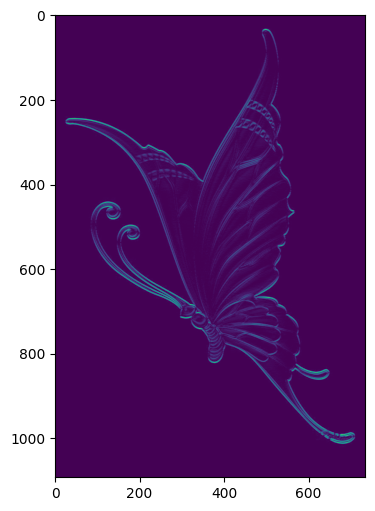

In [26]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

In [27]:
# зададим оператор Собеля для детектирования границ

sobel_ver = [[-1, 0, 1],
             [-2, 0, 2],
             [-1, 0, 1]]

#одна матрица на каждый канал картинки 
kernel = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size()   # число выходных каналов, число входных каналов, высота, ширина

torch.Size([1, 3, 3, 3])

In [28]:
img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size()     # число изображений, высота, ширина, число каналов

torch.Size([1, 1093, 734, 1])

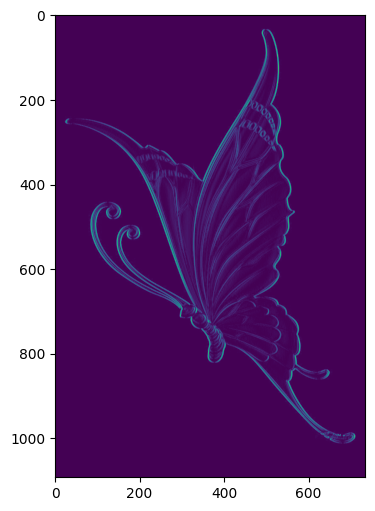

In [29]:
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

**Объединим два изображения**

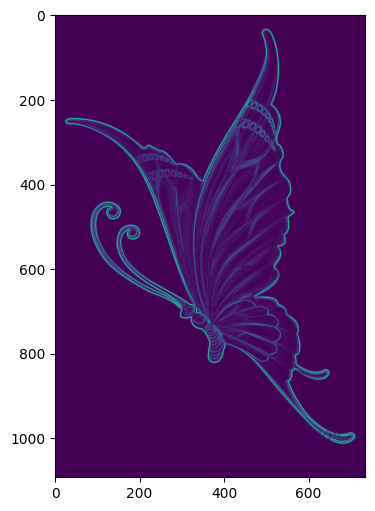

In [31]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

**Задание**

Аналогично, сверните изображение со случайным ядром такого же размера.

Подсказка: используйте `torch.rand()`

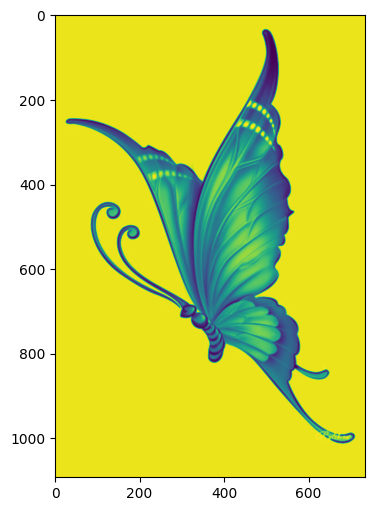

In [35]:
kernel = torch.rand((1, 3, 3, 3), dtype=torch.float)

# свертка изображения
img_conv_ver = conv2d(img_tensor, kernel)
img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)

# рисуем результат 
plt.figure(figsize=(1.5 * 7, 1.5 * 4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

**Полносвязная сеть** (Multilayer perceptron)

Решим задачу классификации изображений полносвязаной нейронной сетью.

In [36]:
import torch.nn.functional as F
import torchvision
from torch import nn

In [37]:
# загрузка и подготовка данных для классификации

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,),(0.3081,) )
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/",
    train=True,
    download=True,
    transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

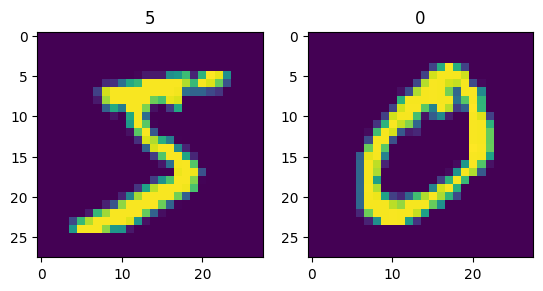

In [38]:
# еще раз посмотрим на то, с чем мы работаем

for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

**Обучаем полносвязную нейронную сеть для классификации изображений так же, как на lab 1**

In [43]:
model = nn.Sequential(
    nn.Flatten(),               # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(28 * 28, 128),    # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),                  # нелинейность 
    nn.Linear(128, 10)          # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)    #создаем оптимизатор и передаем туда параметры модели 

In [45]:
def train(model, optimizer, n_epochs=5):    # в одну эпоху прогоняем все батчи - пройтись по всем данным, одна итерация это 1 батч
    for epoch in range(n_epochs):
        # тренировка
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():       # запрещаем торчу считать градиенты на куске ниже чтобы не тратить ресурсы
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
            
            # печатаем метрики 
            print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

In [46]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.3210991621017456, accuracy: 0.9082


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.2331676185131073, accuracy: 0.9349


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.18676352500915527, accuracy: 0.9462


**Сверточный слой**

добавим в нашу сеть сверточный слой; обратите внимание на то, как изменится качество классификации

In [47]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),   # добавим сверточный слой с 10 ядрами
    nn.ReLU(),                              
    nn.MaxPool2d(kernel_size=4),            # уменьшим картинку в 4 раза по каждой стороне
    nn.Flatten(),                           # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(6*6*10, 128),                 # линейный слой, преобразующий вектор размера 360 в вектор размера 128
    nn.ReLU(),                              # нелинейность
    nn.Linear(128, 10),                     # отображение в пространство размерности числа меток классификации
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [48]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 0.2214643359184265, accuracy: 0.9365


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 0.11711407452821732, accuracy: 0.9667


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 0.08603930473327637, accuracy: 0.9735


**Max Pooling** - берем максимальное значение внутри квадрата изображения во время прохождения фильтра чтобы уменьшить изображение без изменения параметров.

**Mean Pooling** - уменьшение картинки по принципу среднего значения в квадрате под фильтром.